# 频率分析 (1)：从 fchk 文件得到分子频率与简正模式

> 创建时间：2019-10-04

在这份文档中，我们将简单地讨论从 Gaussian 生成的 formated checkpoint 文件 (fchk 或 fch 后缀名)，依据分子的 Hessian 矩阵，给出分子的振动频率与其对应的简正运动模式。

我们所计算的分子是以下显然没有优化到能量最低结构的 C<sub>2</sub>O<sub>4</sub>H<sup>+</sup> 分子。之所以选择这样一个分子，是因为作者希望能正确地计算出虚频。

:::{warning}

不处于能量最低结构的分子一般来说不适合用作频率分析。此时绘制的分子光谱图从理论上是与不可能与实验相符的。

这份文档尽管使用了有虚频的分子，但若要进行真正的光谱绘制，仍然需要先对分子的结构进行优化。

:::

分子结构如下：

In [1]:
from IPython.display import Image

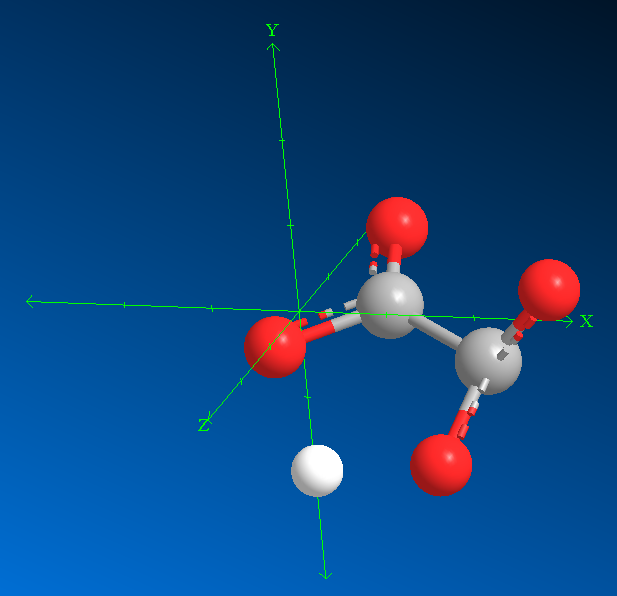

In [2]:
Image(filename="assets/mol_fig.PNG", width=350)

分子对应的输入卡 {download}`C2O4H.gjf`、输出文件 {download}`C2O4H.out` 与 fchk 文件 {download}`C2O4H.fchk` 在链接中可供下载。这份文档的目标将是重复输出文件中的分子频率 `Frequencies` (单位 cm<sup>-1</sup>) 与简正坐标部分；而下一份文档将会重复红外强度 `IR Inten` (单位 km/mol) 与绘制红外光谱。以下是其中一部分频率分析的输出：

In [3]:
with open("C2O4H.out", "r") as f:
    while "and normal coordinates" not in f.readline(): continue
    for _ in range(17): print(f.readline()[:-1])

                     1                      2                      3
                     A                      A                      A
 Frequencies -- -3561.4012             -2816.7847              -111.1073
 Red. masses --     6.8911                 1.1249                14.6979
 Frc consts  --    51.4966                 5.2586                 0.1069
 IR Inten    --  9128.2276              4124.7910                 5.3095
 Raman Activ -- 90326.7283              3896.5620                15.3400
 Depolar (P) --     0.7167                 0.2640                 0.5287
 Depolar (U) --     0.8350                 0.4177                 0.6917
  Atom  AN      X      Y      Z        X      Y      Z        X      Y      Z
     1   6     0.54  -0.07  -0.05     0.04  -0.01   0.03    -0.02   0.16   0.01
     2   8    -0.14   0.02   0.01    -0.03   0.03  -0.03     0.03   0.42   0.26
     3   6    -0.28   0.10  -0.25    -0.04   0.02  -0.03    -0.01   0.10  -0.04
     4   8     0.03  -0.04   0.08

:::{note}

频率分析 (1) 文档的目的与卢天 (Sobereva) 的 `Hess2freq` 程序 [^hess2freq] 的程序基本相同，文档的编写过程也受到不少启发。

但另一方面，这份文档将会解决投影整体平动和转动模式。因此，这份文档原则上应当能通过 Hessian 矩阵，给出更为接近 Gaussian 所输出的频率的结果。而任何量化软件通常都可以计算杂化 GGA 泛函级别的 Hessian，因此这份文档可以用于补足一些不进行频率分析的软件。

这份文档的一个问题会是无法对直线型或说 $3N-5$ 型分子作频率分析。文档中 $3N-6$ 的 $6$ 是 hardcoded 到代码中的。

:::

:::{note}

这篇文档不使用 Einstein Summation Convention。

:::

:::{attention}

事实上，作者并不完全理解整个计算过程的原理；但这似乎是个可行的方案。

:::

## 环境准备

下述引入的包中，

* `FormchkInterface` 可以用来读取 fchk 文件的信息；文件出自 [pyxdh](https://github.com/ajz34/Py_xDH/tree/master) 项目。

* 文档中我们可能会使用众多物理常数。这些由 SciPy 提供，数据来源是 CODATA 2014。

In [4]:
from formchk_interface import FormchkInterface
import numpy as np
from functools import partial
import scipy

np.set_printoptions(5, linewidth=150, suppress=True)
np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])

In [5]:
# https://docs.scipy.org/doc/scipy/reference/constants.html
from scipy.constants import physical_constants

E_h = physical_constants["Hartree energy"][0]
a_0 = physical_constants["Bohr radius"][0]
N_A = physical_constants["Avogadro constant"][0]
c_0 = physical_constants["speed of light in vacuum"][0]
e_c = physical_constants["elementary charge"][0]
e_0 = physical_constants["electric constant"][0]
mu_0 = physical_constants["mag. constant"][0]

现在我们准备分子的数据：

* `natm` 原子数量 $n_\mathrm{Atom}$

* `mol_weight` 原子质量 $w_A$，向量长度 $(n_\mathrm{Atom},)$，单位 amu

* `mol_coord` 原子坐标 $A_t$，矩阵大小 $(n_\mathrm{Atom}, 3)$，单位 Bohr

* `mol_hess` 坐标二阶梯度 (Hessian 矩阵) $E_\mathrm{tot}^{A_t B_s}$，张量大小 $(n_\mathrm{Atom}, 3, n_\mathrm{Atom}, 3)$，单位 E<sub>h</sub> Bohr<sup>-2</sup>

本文档中，$A, B$ 指代原子，$t, s$ 指代坐标分量 $x, y$ 或 $z$。

In [6]:
fchk = FormchkInterface("C2O4H.fchk")

In [7]:
mol_weight = fchk.key_to_value("Real atomic weights")
natm = mol_weight.size
mol_coord = fchk.key_to_value("Current cartesian coordinates").reshape((natm, 3))
mol_hess = fchk.hessian()
mol_hess = (mol_hess + mol_hess.T) / 2
mol_hess = mol_hess.reshape((natm, 3, natm, 3))

## 包含平动、转动的频率

这里按照 `Hess2freq` 程序的思路进行叙述。我们首先生成带原子质量权重的力常数张量 `theta`

$$
\Theta^{A_t B_s} = E_\mathrm{tot}^{A_t B_s} / \sqrt{w_A w_B}
$$

但为了程序便利，我们重定义 `theta` 的维度信息为 $(3 n_\mathrm{Atom}, 3 n_\mathrm{Atom})$；单位是 E<sub>h</sub> Bohr<sup>-2</sup> amu<sup>-1</sup>。

In [8]:
theta = np.einsum("AtBs, A, B -> AtBs", mol_hess, 1 / np.sqrt(mol_weight), 1 / np.sqrt(mol_weight)).reshape(3 * natm, 3 * natm)

随后，我们对其进行对角化，可以立即得到原始的分子频率 `e` 与简正坐标 `q`，且维度分别是 $(3 n_\mathrm{Atom}, 3 n_\mathrm{Atom})$ 与 $(3 n_\mathrm{Atom},)$。注意到 `e` 的单位是 E<sub>h</sub> Bohr<sup>-2</sup> amu<sup>-1</sup>，而 `q` 现在是无量纲量。

In [9]:
e, q = np.linalg.eigh(theta)

现在获得的原始分子频率事实上是力常数除以质量的结果，或者按照 Levine (7ed) p63, eq (4.23) 的表达，为 $k/m$。因此，化为以波数表示的频率 `freq_cm_1` 的公式是

$$
\tilde \nu = \frac{1}{2 \pi c_0} \sqrt{\frac{k}{m}}
$$

其中，$c_0$ 表示真空光速。在实行具体计算前，需要将单位转换为国际单位制。最终会将频率转成 cm<sup>-1</sup> 单位。

In [10]:
freq_cm_1 = np.sqrt(np.abs(e * E_h * 1000 * N_A / a_0**2)) / (2 * np.pi * c_0 * 100) * ((e > 0) * 2 - 1)
freq_cm_1

array([-3561.40505, -2816.91767,  -168.16445,  -156.49378,  -118.3671 ,    -0.05708,     0.00635,     0.02696,    43.3215 ,   289.57484,   359.82004,
         542.70646,   584.63229,   646.04288,   680.41788,   775.32894,  1115.58713,  1346.89469,  1521.52455,  1593.04881,  1969.81362])

需要留意，复数的频率实际上是虚数频率，或者说是现实中不存在的频率；使用复数表示这些频率仅仅是为了程序方便，以及约定俗称的原因。

由于分子的振动自由度 (对于非线性分子) 是 $3 n_\mathrm{Atom} - 6$，因此其中有 6 个频率不应当归属于振动频率中。大多数情况下，舍去绝对值最小的六个频率即可；但其值仍然会与 Gaussian 给出的结果有少许的不同。

简正坐标在这里我们暂时不进行更多说明；在叙述去除平动、转动的频率后，我们再讨论简正坐标的导出。

## 去除平动、转动的频率

去除平动、转动对频率的贡献，其过程大致是预先将平动、转动的模式求取，随后将力常数张量投影到平动、转动模式的补空间 ($3 n_\mathrm{Atom} - 6$ 维度空间)，得到新的力常数张量。

其中的大部分内容应当在 Wilson et al. [^Wilson-Cross.Dover.1980] 的 Chapter 2 可以找到。

### 质心坐标

`center_coord` $C_t$ 表示质心坐标，维度 $(3,)$，单位 Bohr。

$$
C_{t} = \frac{\sum_{A} A_{t} w_A}{\sum_A w_A}
$$

In [11]:
center_coord = (mol_coord * mol_weight[:, None]).sum(axis=0) / mol_weight.sum()
center_coord

array([ 2.56385, -0.44307, -0.07436])

`centered_coord` $A^\mathrm{C}_t$ 是将质心平移至原点后的原子坐标，维度 $(n_\mathrm{Atom}, 3)$，单位 Bohr。

$$
A^\mathrm{C}_t = A_t - C_t
$$

In [12]:
centered_coord = mol_coord - center_coord

### 转动惯量本征向量

`rot_tmp` $I_{ts}$ 是转动惯量相关的矩阵，在初始化时维度为 $(n_\mathrm{Atom}, 3, 3)$，最终结果通过求和得到 $(3, 3)$ 的矩阵，单位 Bohr<sup>2</sup> amu。

$$
\begin{split}
I_{ts} =
\begin{cases}
    \sum_{A} w_A \left( - (A_t^\mathrm{C})^2 + \sum_r (A_r^\mathrm{C})^2 \right) \,, & t = s \\
    \sum_{A} w_A \left( - A_t^\mathrm{C} A_s^\mathrm{C} \right) \,, & t \neq s
\end{cases}
\end{split}
$$

In [13]:
rot_tmp = np.zeros((natm, 3, 3))
rot_tmp[:, 0, 0] = centered_coord[:, 1]**2 + centered_coord[:, 2]**2
rot_tmp[:, 1, 1] = centered_coord[:, 2]**2 + centered_coord[:, 0]**2
rot_tmp[:, 2, 2] = centered_coord[:, 0]**2 + centered_coord[:, 1]**2
rot_tmp[:, 0, 1] = rot_tmp[:, 1, 0] = - centered_coord[:, 0] * centered_coord[:, 1]
rot_tmp[:, 1, 2] = rot_tmp[:, 2, 1] = - centered_coord[:, 1] * centered_coord[:, 2]
rot_tmp[:, 2, 0] = rot_tmp[:, 0, 2] = - centered_coord[:, 2] * centered_coord[:, 0]
rot_tmp = (rot_tmp * mol_weight[:, None, None]).sum(axis=0)

`rot_eig` $R_{ts}$ 是转动惯量相关的对称矩阵 $I_{ts}$ 所求得的本征向量，维度 $(3, 3)$，无量纲。

In [14]:
_, rot_eig = np.linalg.eigh(rot_tmp)
rot_eig

array([[ 0.80658, -0.54971,  0.21739],
       [-0.16056, -0.55765, -0.8144 ],
       [ 0.56891,  0.62197, -0.53805]])

### 平动、转动投影矩阵

`proj_scr` $P_{A_t q}$ 是平动、转动的 $(3 n_\mathrm{Atom}, 6)$ 维度投影矩阵，其目的是将 $\Theta^{A_t B_s}$ 中不应对分子振动产生贡献的部分投影消去，剩余的 $3 n_\mathrm{Atom} - 6$ 子空间用于求取实际的分子振动频率。但在初始化 `proj_scr` $P_{A_t q}$ 时，先使用 $(n_\mathrm{Atom}, 3, 6)$ 维度的张量。

在计算投影矩阵前，我们先生成 `rot_coord` $\mathscr{R}_{Asrw}$ 转动投影相关量，维度 $(n_\mathrm{Atom}, 3, 3, 3)$：

$$
\mathscr{R}_{Asrw} = \sum_{t} A^\mathrm{C}_t R_{ts} R_{rw}
$$

In [15]:
rot_coord = np.einsum("At, ts, rw -> Asrw", centered_coord, rot_eig, rot_eig)
rot_coord.shape

(7, 3, 3, 3)

随后我们给出 `proj_scr` 的计算表达式。`proj_scr` 的前三列表示平动投影，当 $q \in (x, y, z) = (0, 1, 2)$ 时，

$$
P_{A_t q} = \sqrt{w_A} \delta_{tq}
$$

而当 $q \in (x, y, z) = (3, 4, 5)$ 时，

$$
\begin{split}
P_{A_t q} = \sqrt{w_A} \times
\begin{cases}
    \mathscr{R}_{Aytz} - \mathscr{R}_{Azty} \,, & q = x \\
    \mathscr{R}_{Aztx} - \mathscr{R}_{Axtz} \,, & q = y \\
    \mathscr{R}_{Axty} - \mathscr{R}_{Aytx} \,, & q = z
\end{cases}
\end{split}
$$

最终，我们会将 $P_{A_t q}$ 中关于 $A_t$ 的维度进行归一化，因此最终获得的 $P_{A_t q}$ 是无量纲的。

In [16]:
proj_scr = np.zeros((natm, 3, 6))
proj_scr[:, (0, 1, 2), (0, 1, 2)] = 1
proj_scr[:, :, 3] = (rot_coord[:, 1, :, 2] - rot_coord[:, 2, :, 1])
proj_scr[:, :, 4] = (rot_coord[:, 2, :, 0] - rot_coord[:, 0, :, 2])
proj_scr[:, :, 5] = (rot_coord[:, 0, :, 1] - rot_coord[:, 1, :, 0])
proj_scr *= np.sqrt(mol_weight)[:, None, None]
proj_scr.shape = (-1, 6)
proj_scr /= np.linalg.norm(proj_scr, axis=0)
proj_scr

array([[ 0.36722,  0.     ,  0.     ,  0.00369,  0.05794,  0.11255],
       [ 0.     ,  0.36722,  0.     ,  0.04243, -0.17071,  0.09139],
       [ 0.     ,  0.     ,  0.36722,  0.00675, -0.10185, -0.09286],
       [ 0.42396,  0.     ,  0.     ,  0.01229, -0.02015, -0.0705 ],
       [ 0.     ,  0.42396,  0.     , -0.49194, -0.29189,  0.22557],
       [ 0.     ,  0.     ,  0.42396, -0.15626, -0.27952, -0.36992],
       [ 0.36722,  0.     ,  0.     ,  0.03114,  0.00301, -0.06566],
       [ 0.     ,  0.36722,  0.     ,  0.11694,  0.18118, -0.11688],
       [ 0.     ,  0.     ,  0.36722, -0.01115,  0.16511,  0.15039],
       [ 0.42396,  0.     ,  0.     ,  0.16731, -0.02119, -0.43088],
       [ 0.     ,  0.42396,  0.     , -0.30661,  0.34319, -0.15655],
       [ 0.     ,  0.     ,  0.42396, -0.32374,  0.28897,  0.06287],
       [ 0.42396,  0.     ,  0.     , -0.02565,  0.18716,  0.45037],
       [ 0.     ,  0.42396,  0.     ,  0.3913 , -0.45793,  0.21108],
       [ 0.     ,  0.     ,  0.423

最后我们声明，在经过上述投影后的力常数矩阵几乎表现为零：

$$
\mathbf{P}^\dagger \mathbf{\Theta} \mathbf{P} \simeq \mathbf{0}
$$

In [17]:
proj_scr.T @ theta @ proj_scr

array([[-0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [-0.     , -0.     ,  0.     , -0.00034,  0.00053, -0.00012],
       [-0.     , -0.     ,  0.     ,  0.00053,  0.00001,  0.00011],
       [ 0.     , -0.     ,  0.     , -0.00012,  0.00011, -0.00021]])

对上述矩阵进行对角化所给出的平动、转动频率如下：

In [18]:
e_tr, _ = np.linalg.eigh(proj_scr.T @ theta @ proj_scr)
np.sqrt(np.abs(e_tr * E_h * 1000 * N_A / a_0**2)) / (2 * np.pi * c_0 * 100) * ((e_tr > 0) * 2 - 1)

array([-142.94819,  -65.35067,   -0.05708,    0.00635,    0.02696,  102.63548])

### 平动、转动投影矩阵的补空间

既然我们已经得到了平动、转动的投影，那么根据矩阵的原理，相应地我们也能获得其补空间的投影。我们令 `proj_inv` $Q_{A_t q}$ 为 $P_{A_t q}$ 的补空间投影。获得补空间的大致方式是预先定义一个仅有一个分量为 $1$ 的 $(3 n_\mathrm{Atom}, )$ 维度向量，随后通过 Schmit 正交的方式给出已有投影空间的补空间向量。组合这些 Schmit 正交的向量便获得了 $Q_{A_t q}$。

$Q_{A_t q}$ 的维度本应当是 $(3 n_\mathrm{Atom}, 3 n_\mathrm{Atom} - 6)$ 维。但为了程序编写方便，我们先规定 `proj_inv` 是 $(3 n_\mathrm{Atom}, 3 n_\mathrm{Atom})$ 维度，并且其中的前 6 列填入 $P_{A_t q}$；在进行 Schmit 正交化后，再将前 6 列剔除。

In [19]:
proj_inv = np.zeros((natm * 3, natm * 3))
proj_inv[:, :6] = proj_scr

In [20]:
x_col = 6 - 1
for A_col in range(6, natm * 3):
    stat = True
    while stat:  # first xcol - 6 values in vector t should be zero
        x_col += 1
        x0 = np.zeros((natm * 3, ))
        x0[x_col - 6] = 1
        t = x0 - proj_inv[:, :A_col].T @ x0 @ proj_inv[:, :A_col].T
        t /= np.linalg.norm(t)
        stat = (np.linalg.norm(t[:x_col - 6]) > 1e-7)
    proj_inv[:, A_col] = t
proj_inv = proj_inv[:, 6:]

我们最后获得的 $Q_{A_t q}$ 是列正交切归一的矩阵，且形式大致是下三角矩阵。但需要留意，对于当前的分子，最后一列只有 6 个非零值，与倒数第二列非零值的数量相差 2 个。

In [21]:
proj_inv[:, :8]

array([[ 0.92147,  0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     ],
       [-0.0006 ,  0.90876,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     ],
       [ 0.01772, -0.0101 ,  0.91962,  0.     ,  0.     , -0.     , -0.     ,  0.     ],
       [-0.15913,  0.00263, -0.00635,  0.88846, -0.     ,  0.     ,  0.     ,  0.     ],
       [-0.00723, -0.22587, -0.00828,  0.0174 ,  0.62508,  0.     ,  0.     ,  0.     ],
       [ 0.06338, -0.00797, -0.23777, -0.02386, -0.12464,  0.71004,  0.     , -0.     ],
       [-0.13864,  0.00562, -0.00379, -0.20568,  0.05571, -0.01213,  0.89165, -0.     ],
       [ 0.00242, -0.10806,  0.00617, -0.00599, -0.06901,  0.02449, -0.00896,  0.88757],
       [-0.02871,  0.01639, -0.11235,  0.00984,  0.01789, -0.10978,  0.00552, -0.00503],
       [-0.11566,  0.03146, -0.04451, -0.26042,  0.29396, -0.15738, -0.31106, -0.0477 ],
       [-0.00123, -0.07679,  0.02363, -0.00022, -0.33955, -0.06639,  0.01868, -0.25957],
       [-0.02455,  0.

In [22]:
proj_inv[:, 8:]

array([[ 0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ],
       [ 0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     ],
       [-0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ],
       [ 0.     ,  0.     , -0.     , -0.     , -0.     , -0.     , -0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     ],
       [-0.     , -0.     , -0.     , -0.     , -0.     , -0.     , -0.     ],
       [ 0.88821,  0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.04822,  0.55628, -0.     , -0.     ,  0.     ,  0.     ,  0.     ],
       [-0.03972,  0.14218,  0.60686,  0.     ,  0.     , -0.     ,  0.     ],
       [-0.28906,  0.17446, -0.45345,  0.46401,  0.     , -0.     , -0.     ],
       [-0.06431, -0.06973, -0.00436, -0.05117,  0.5

### 去除平动、转动部分的频率

我们将对矩阵 $\mathbf{Q}^\dagger \mathbf{\Theta} \mathbf{Q}$ 进行对角化；且获得的第 $q$ 个简正坐标的频率相关量 `e` $K_q = k_q / m_q$ 与原始简正坐标 `q` $\mathbf{q}^\mathrm{orig}$ 表示如下：

$$
\mathbf{Q}^\dagger \mathbf{\Theta} \mathbf{Q} \mathbf{q}^\mathrm{orig} = \mathbf{q}^\mathrm{orig} \mathrm{diag} (\boldsymbol{K})
$$

In [23]:
e, q = np.linalg.eigh(proj_inv.T @ theta @ proj_inv)

由此，我们就可以立即获得去除平动、转动部分的，以 cm<sup>-1</sup> 为单位的，总数为 $3 n_\mathrm{Atom} - 6$ 的分子频率 `freq_cm_1`：

In [24]:
freq_cm_1 = np.sqrt(np.abs(e * E_h * 1000 * N_A / a_0**2)) / (2 * np.pi * c_0 * 100) * ((e > 0) * 2 - 1)
freq_cm_1

array([-3561.40117, -2816.7847 ,  -111.10727,   285.51964,   354.79005,   541.46285,   583.67422,   641.59573,   678.70706,   774.75315,  1114.8334 ,
        1341.17965,  1521.15243,  1592.00939,  1969.72731])

### 归一化的简正坐标

方才通过对角化，我们获得的原始简正坐标 `q` 的维度是 $3 n_\mathrm{Atom} - 6$。我们需要通过 `q` $\mathbf{q}^\mathrm{orig}$ 重塑回正常的简正坐标的维度 $q_{A_t q}$ $(3 n_\mathrm{Atom}, 3 n_\mathrm{Atom} - 6)$。

我们首先给出未经过归一化的简正坐标，命名为 `q_unnormed` $q_{A_t q}^\mathrm{unnorm}$，其单位是 amu<sup>-1/2</sup>。该量将会用于后续的红外强度计算上。其计算过程大致是

$$
\mathbf{q}^\mathrm{unnorm} = \mathbf{Q} \mathbf{q}^\mathrm{orig} / \sqrt{\mathbf{w}}
$$

In [25]:
q_unnormed = np.einsum("AtQ, A -> AtQ", (proj_inv @ q).reshape(natm, 3, (proj_inv @ q).shape[-1]), 1 / np.sqrt(mol_weight))
q_unnormed = q_unnormed.reshape(-1, q_unnormed.shape[-1])

而将每一个简正坐标的振动强度归一化的矩阵称为 `q_normed` $q_{A_t q}$；它是我们的目标的简正坐标。

In [26]:
q_normed = q_unnormed / np.linalg.norm(q_unnormed, axis=0)

我们可以以下述代码核对前三个简正坐标。这些坐标应当与 Gaussian 所输出的坐标几乎相同，或刚好相差正负号。

In [27]:
q_normed.reshape(natm, 3, 3 * natm - 6)[:, :, :3].transpose((2, 0, 1))

array([[[-0.54001,  0.07088,  0.04608],
        [ 0.14273, -0.02387, -0.00516],
        [ 0.284  , -0.09918,  0.24533],
        [-0.03237,  0.03565, -0.07878],
        [ 0.12144,  0.02845, -0.08535],
        [-0.08194, -0.03046, -0.05426],
        [ 0.66966,  0.18195,  0.07812]],

       [[-0.0408 ,  0.01485, -0.03176],
        [ 0.02602, -0.02747,  0.02887],
        [ 0.03581, -0.01862,  0.02587],
        [ 0.02413,  0.01192, -0.01877],
        [ 0.01187, -0.00732,  0.02008],
        [-0.0026 ,  0.0054 , -0.00522],
        [-0.88356,  0.32216, -0.32609]],

       [[ 0.02081, -0.165  , -0.00726],
        [-0.02702, -0.41713, -0.26319],
        [ 0.01085, -0.09639,  0.03556],
        [-0.09566,  0.32921,  0.34068],
        [-0.03741,  0.46378,  0.19918],
        [ 0.13693, -0.19313, -0.30902],
        [-0.00955,  0.21243,  0.17633]]])

[^hess2freq]: <http://sobereva.com/328>

[^Wilson-Cross.Dover.1980]: Wilson, E. B.; Decius, J. C.; Cross, P. C. *Molecular Vibrations*; Dover Pub. Inc., 1980.